In [51]:
%load_ext autoreload
%reload_ext autoreload
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('SRC_PATH'))

import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from src.volsurface import GridInterpVolSurface, KernelVolSurface
from src.utils.data_helper import clean_data, VolSurfPointwiseDataset

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from src.train import Trainer

from src.volsurface import VAEPWVolSurface, VAEVolSurface
# from src.volsurface import TrainedDecoderVolSurface

import json

DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('future.no_silent_downcasting', True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from src.utils.logger import setup_logger
logger = setup_logger('train')

In [53]:
query = """
SELECT date, symbol, exdate, last_date, cp_flag, strike_price, best_bid, best_offer, volume, open_interest, impl_volatility, delta
FROM opprc
"""
dtype = {
    'symbol': 'string',
    'cp_flag': 'string',
    'strike_price': 'float64',
    'best_bid': 'float64',
    'best_offer': 'float64',
    'volume': 'int64',
    'open_interest': 'int64',
    'impl_volatility': 'float64',
    'delta': 'float64'
}
df_raw = pd.read_sql_query(query, conn, parse_dates=['date', 'exdate', 'last_date'])
df_raw = df_raw.replace('', np.nan) # sqlite returns empty strings for NULL values
df_raw = df_raw.astype(dtype)

df = clean_data(df_raw)

[2025-04-20 12:49:10] [INFO] src.utils.data_helper (50) : Bad data - Filtered 1110238 rows, Retained sample 76.67%
[2025-04-20 12:49:21] [INFO] src.utils.data_helper (63) : Consecutive trading stats completed
[2025-04-20 12:49:23] [INFO] src.utils.data_helper (86) : Consecutive trading - Filtered 2341950 rows, Retained sample 35.81%
[2025-04-20 12:49:23] [INFO] src.utils.data_helper (91) : Moneyness calculation completed


In [54]:
model_name = "vae_pw_improve"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

In [55]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [56]:
SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer = Trainer(model_name)
trainer.create_model()

[2025-04-20 12:49:28] [ERROR] src.train (38) : Model configs not found


AttributeError: 'Trainer' object has no attribute 'network_param'

In [57]:
with open(data_dir, "r") as f:
    data = json.load(f)

In [58]:
mapping_ids = {dt: i for i, dt in enumerate(sorted(map(lambda x: x[:10], data.keys())))}

In [59]:
df['mapping_ids'] = df['date'].dt.strftime('%Y-%m-%d').map(mapping_ids)

In [60]:
vol_surfaces = []
for key in sorted(data.keys()):
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
pw_grid_data = torch.tensor(df[['ttm', 'moneyness']].values, dtype=torch.float32)
# !only for test run
pw_grid_data[:, 0] = pw_grid_data[:, 0] / 365.0
pw_vol_data = torch.tensor(df['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

In [62]:
pw_grid_data.shape

torch.Size([1306655, 2])

In [23]:
dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer.batch_size,
    shuffle=True
)

In [24]:
# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer.train(train_loader)

[2025-04-18 16:07:45] [INFO] train (3) : Epoch 1/10
[2025-04-18 16:09:11] [INFO] src.train (180) : Loss: 0.0056
[2025-04-18 16:09:11] [INFO] train (3) : Epoch 2/10
[2025-04-18 16:10:37] [INFO] src.train (180) : Loss: 0.0042
[2025-04-18 16:10:37] [INFO] train (3) : Epoch 3/10
[2025-04-18 16:12:02] [INFO] src.train (180) : Loss: 0.0040
[2025-04-18 16:12:02] [INFO] train (3) : Epoch 4/10
[2025-04-18 16:13:28] [INFO] src.train (180) : Loss: 0.0039
[2025-04-18 16:13:28] [INFO] train (3) : Epoch 5/10
[2025-04-18 16:14:53] [INFO] src.train (180) : Loss: 0.0038
[2025-04-18 16:14:53] [INFO] train (3) : Epoch 6/10
[2025-04-18 16:16:18] [INFO] src.train (180) : Loss: 0.0038
[2025-04-18 16:16:18] [INFO] train (3) : Epoch 7/10
[2025-04-18 16:17:43] [INFO] src.train (180) : Loss: 0.0037
[2025-04-18 16:17:43] [INFO] train (3) : Epoch 8/10
[2025-04-18 16:19:08] [INFO] src.train (180) : Loss: 0.0037
[2025-04-18 16:19:08] [INFO] train (3) : Epoch 9/10
[2025-04-18 16:20:33] [INFO] src.train (180) : Loss:

In [25]:
torch.save(trainer.model.state_dict(), f"params/{trainer.model_name}.pth")

In [3]:
model_name = "vae_pw_improve"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer = Trainer(model_name)
trainer.create_model()

trainer.load_model( f"params/{trainer.model_name}.pth")

[2025-04-18 16:50:53] [INFO] src.train (61) : Using device: mps


[2025-04-18 16:50:53] [INFO] src.train (137) : Model loaded from params/vae_pw_improve.pth


In [4]:
def normal_rng(shape, mean=0.0, std=1.0):
    rng = np.random.default_rng(seed=42)
    while True:
        yield rng.normal(loc=mean, scale=std, size=shape)

test_rng = normal_rng(4)

maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [5]:
# vae_gen = VAEPWVolSurface(
#     vae_model=trainer.model
# )

vae_gen = TrainedDecoderVolSurface(
    model_type = "vae_pw_ii",
    model = trainer.model,
    maturity_range=(min(maturity_grid), 180.0),
    random_src=test_rng
)

In [6]:
vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)

array([[0.16829248, 0.16847183, 0.16922516, 0.17040145, 0.1718966 ,
        0.18073519, 0.33278432, 0.999972  ],
       [0.1650085 , 0.16518506, 0.16592665, 0.16708462, 0.16855659,
        0.17726018, 0.3916126 , 0.9999428 ],
       [0.1637348 , 0.16391024, 0.16464727, 0.16579807, 0.16726097,
        0.17591181, 0.40229282, 0.9999337 ],
       [0.16257069, 0.16274515, 0.16347791, 0.16462216, 0.16607675,
        0.1763866 , 0.41191897, 0.99992967],
       [0.16132714, 0.1615005 , 0.16222876, 0.16336598, 0.16546471,
        0.17804   , 0.42458525, 0.9999267 ],
       [0.16199651, 0.1622491 , 0.1633113 , 0.16497387, 0.16709413,
        0.17976655, 0.43788004, 0.99992335],
       [0.16352832, 0.16378284, 0.1648531 , 0.16652824, 0.16866443,
        0.18143001, 0.4506896 , 0.9999201 ],
       [0.1649578 , 0.1652141 , 0.16629185, 0.16797869, 0.17012967,
        0.18298174, 0.46260577, 0.9999176 ],
       [0.16626474, 0.16652267, 0.16760725, 0.16930471, 0.17146915,
        0.18439993, 0.473445

<Axes3D: title={'center': 'Volatility Surface'}, xlabel='Delta', ylabel='Maturity', zlabel='Implied Volatility'>

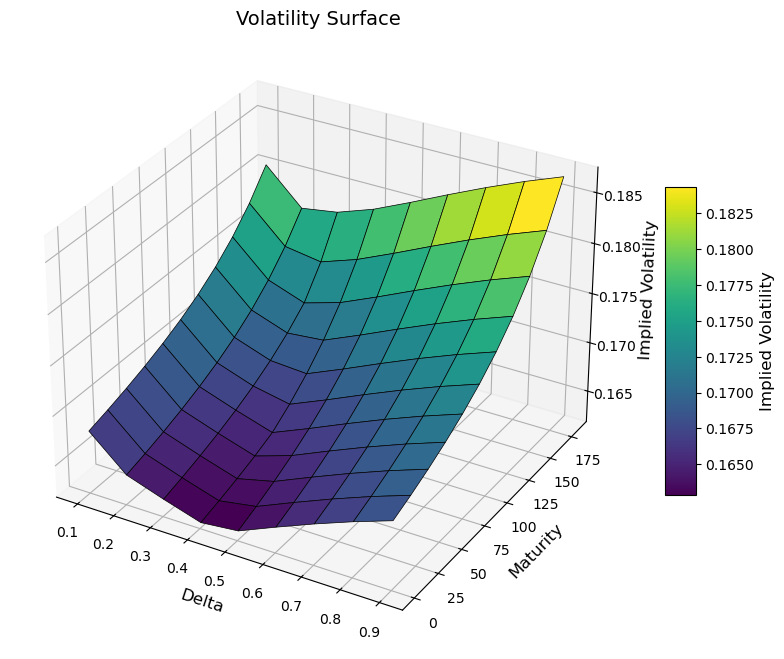

In [7]:
vae_gen.refresh()
vae_gen.plot()

In [9]:
trainer.model.decoder

VaeDecoder(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

In [7]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
vol_to_plot = vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)
maturity, delta = np.meshgrid(maturity_grid, delta_grid)

# Plot the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(delta, maturity, vol_to_plot, cmap='viridis')

# Add labels and color bar
ax.set_xlabel('Maturity')
ax.set_ylabel('Delta')
ax.set_zlabel('Volatility')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.show()

RuntimeError: Tensor for argument input is on cpu but expected on mps

In [31]:
vol_to_plot

array([[0.37968704, 0.6750476 , 0.17719653, 0.769959  , 0.2122437 ,
        0.24602956, 0.3565432 , 0.7517451 ],
       [0.43030462, 0.8006334 , 0.17959552, 0.86836994, 0.85131115,
        0.25495622, 0.88234425, 0.8709743 ],
       [0.4552278 , 0.92609894, 0.17670971, 0.9148289 , 0.937419  ,
        0.2584535 , 0.9356896 , 0.9328074 ],
       [0.46832147, 0.9712659 , 0.1753517 , 0.9738574 , 0.9643874 ,
        0.26178977, 0.9626569 , 0.97556317],
       [0.4807782 , 0.9855538 , 0.17707272, 0.9869588 , 0.9781491 ,
        0.26498455, 0.9766817 , 0.9903391 ],
       [0.4925999 , 0.99143034, 0.17871334, 0.9932568 , 0.9870105 ,
        0.26803088, 0.99185526, 0.9954204 ],
       [0.5037164 , 0.9931912 , 0.18026209, 0.9970964 , 0.9959182 ,
        0.27090815, 0.99736375, 0.9975447 ],
       [0.51403046, 0.9940807 , 0.18170524, 0.9986351 , 0.9985672 ,
        0.27359042, 0.9985129 , 0.99855715],
       [0.52344346, 0.9947901 , 0.18302871, 0.99928814, 0.9992353 ,
        0.27605113, 0.999141

delta_embed torch.Size([121, 4])
maturity_embed torch.Size([121, 4])
latent torch.Size([121, 4])


<Axes3D: title={'center': 'Volatility Surface'}, xlabel='Delta', ylabel='Maturity', zlabel='Implied Volatility'>

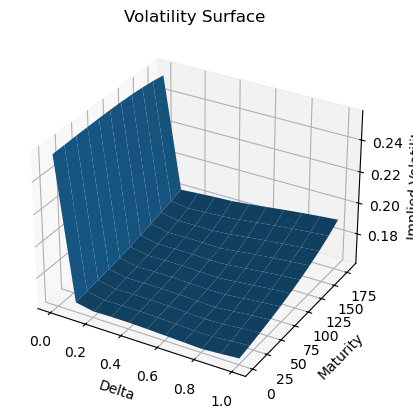

In [7]:
tdvs.refresh()
tdvs.plot()

# Grid adjust, vae_pw_ii, previous version git e1f95271f2b421449a4dc9f2e2c3fce5ab88faea

In [17]:
delta_grid = np.linspace(0.05, 0.95, 21)
maturity_grid = maturity_grid = np.array([1, 7] + [30 * i for i in range(1, 13) if 30 * i <= 720])
print(len(maturity_grid) * len(delta_grid))

294


In [18]:
model_name = "vae_pw_ii_grid_2"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces_2.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer_grid_2 = Trainer(model_name)
trainer_grid_2.create_model()

[2025-04-19 22:48:47] [INFO] src.train (60) : Using device: mps


In [19]:
with open(data_dir, "r") as f:
    data = json.load(f)

mapping_ids = {dt: i for i, dt in enumerate(sorted(map(lambda x: x[:10], data.keys())))}

df['mapping_ids'] = df['date'].dt.strftime('%Y-%m-%d').map(mapping_ids)

vol_surfaces = []
for key in sorted(data.keys()):
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
pw_grid_data = torch.tensor(df[['ttm', 'moneyness']].values, dtype=torch.float32)
# !only for test run
pw_grid_data[:, 0] = pw_grid_data[:, 0] / 365.0
pw_vol_data = torch.tensor(df['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

In [21]:
dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer_grid_2.batch_size,
    shuffle=True
)

In [48]:
# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer_grid_2.train(train_loader)

[2025-04-18 17:43:10] [INFO] train (3) : Epoch 1/10
[2025-04-18 17:43:10] [INFO] train (3) : Epoch 1/10
[2025-04-18 17:44:37] [INFO] src.train (180) : Loss: 0.0050
[2025-04-18 17:44:37] [INFO] train (3) : Epoch 2/10
[2025-04-18 17:44:37] [INFO] train (3) : Epoch 2/10
[2025-04-18 17:46:03] [INFO] src.train (180) : Loss: 0.0042
[2025-04-18 17:46:03] [INFO] train (3) : Epoch 3/10
[2025-04-18 17:46:03] [INFO] train (3) : Epoch 3/10
[2025-04-18 17:47:30] [INFO] src.train (180) : Loss: 0.0040
[2025-04-18 17:47:30] [INFO] train (3) : Epoch 4/10
[2025-04-18 17:47:30] [INFO] train (3) : Epoch 4/10
[2025-04-18 17:48:57] [INFO] src.train (180) : Loss: 0.0039
[2025-04-18 17:48:57] [INFO] train (3) : Epoch 5/10
[2025-04-18 17:48:57] [INFO] train (3) : Epoch 5/10
[2025-04-18 17:50:24] [INFO] src.train (180) : Loss: 0.0038
[2025-04-18 17:50:24] [INFO] train (3) : Epoch 6/10
[2025-04-18 17:50:24] [INFO] train (3) : Epoch 6/10
[2025-04-18 17:51:48] [INFO] src.train (180) : Loss: 0.0038
[2025-04-18 17:5

In [49]:
torch.save(trainer_grid_2.model.state_dict(), f"params/{trainer_grid_2.model_name}.pth")

In [22]:
trainer_grid_2.load_model( f"params/{trainer_grid_2.model_name}.pth")

[2025-04-19 22:49:21] [INFO] src.train (136) : Model loaded from params/vae_pw_ii_grid_2.pth


In [23]:
def normal_rng(shape, mean=0.0, std=1.0):
    rng = np.random.default_rng(seed=42)
    while True:
        yield rng.normal(loc=mean, scale=std, size=shape)

test_rng = normal_rng(4)

In [24]:
vae_gen = VAEPWVolSurface(
    vae_model=trainer_grid_2.model
)

vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)

array([[0.16599812, 0.16411084, 0.16984247, 0.1783453 , 0.18451509,
        0.18938719, 0.19343387, 0.1969062 , 0.19995295, 0.20327418,
        0.20940655, 0.21664104, 0.2340363 , 0.26361948],
       [0.15955302, 0.15694702, 0.16609411, 0.1744487 , 0.18051328,
        0.18530375, 0.19346434, 0.20221968, 0.21002334, 0.21707289,
        0.22350477, 0.2397826 , 0.258423  , 0.29557425],
       [0.15743577, 0.15485798, 0.16390699, 0.17217429, 0.17916483,
        0.19131066, 0.20164186, 0.21067065, 0.21871105, 0.22596878,
        0.23472226, 0.25499505, 0.27439123, 0.3167648 ],
       [0.15648603, 0.15392095, 0.16292575, 0.17115371, 0.18307465,
        0.19542241, 0.20591912, 0.21508788, 0.22324914, 0.23061301,
        0.2423674 , 0.26307356, 0.2828509 , 0.3284174 ],
       [0.15610534, 0.15354536, 0.16253242, 0.17074455, 0.18512286,
        0.19757536, 0.20815778, 0.2173989 , 0.22562265, 0.23304133,
        0.24649255, 0.2674267 , 0.2874037 , 0.33530736],
       [0.15593432, 0.15337664, 0.1

<Axes3D: title={'center': 'Volatility Surface'}, xlabel='Delta', ylabel='Maturity', zlabel='Implied Volatility'>

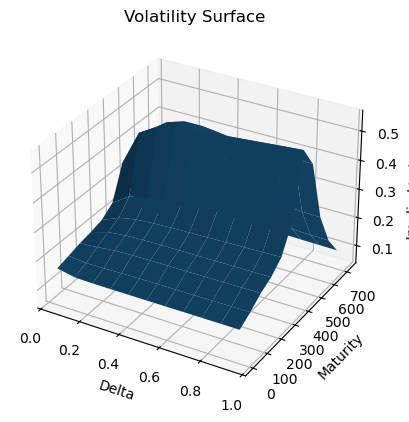

In [47]:
vae_gen.refresh()
vae_gen.plot(delta_range=(0.05, 0.95), maturity_range=(1, 720))

# grid adjust, filter out large ttm

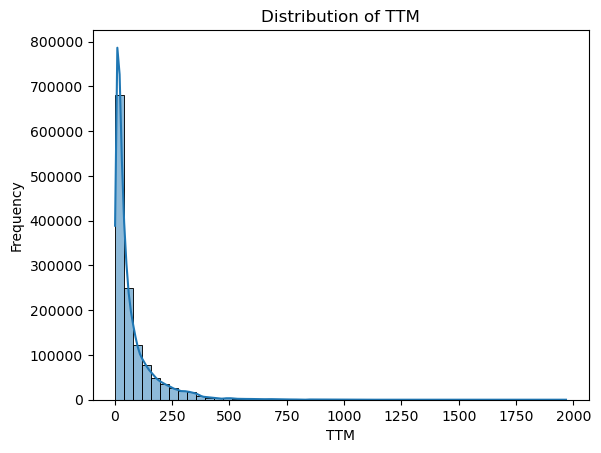

In [50]:
from matplotlib import pyplot as plt
sns.histplot(df['ttm'], bins=50, kde=True)
plt.title('Distribution of TTM')
plt.xlabel('TTM')
plt.ylabel('Frequency')
plt.show()

In [54]:
df_short = df[df['ttm'] <= 500]
delta_grid = np.linspace(0.1, 0.9, 9)
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360])
model_name = "vae_pw_ii_shortttm"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces_shortttm.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer_shortttm = Trainer(model_name)
trainer_shortttm.create_model()

[2025-04-19 23:30:02] [INFO] src.train (60) : Using device: mps


In [55]:
with open(data_dir, "r") as f:
    data = json.load(f)

mapping_ids = {dt: i for i, dt in enumerate(sorted(map(lambda x: x[:10], data.keys())))}

df_short['mapping_ids'] = df_short['date'].dt.strftime('%Y-%m-%d').map(mapping_ids)

vol_surfaces = []
for key in sorted(data.keys()):
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
pw_grid_data = torch.tensor(df_short[['ttm', 'moneyness']].values, dtype=torch.float32)
# !only for test run
pw_grid_data[:, 0] = pw_grid_data[:, 0] / 365.0
pw_vol_data = torch.tensor(df_short['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df_short['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

/var/folders/dv/hcj1_ccx5cj5cw1rpkpk9x_h0000gn/T/ipykernel_46251/1322124020.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short['mapping_ids'] = df_short['date'].dt.strftime('%Y-%m-%d').map(mapping_ids)


In [56]:
dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer_shortttm.batch_size,
    shuffle=True
)

In [60]:
# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer_shortttm.train(train_loader)

[2025-04-19 23:32:21] [INFO] train (3) : Epoch 1/10
[2025-04-19 23:32:21] [INFO] train (3) : Epoch 1/10
[2025-04-19 23:33:32] [INFO] src.train (179) : Loss: 0.0063
[2025-04-19 23:33:32] [INFO] train (3) : Epoch 2/10
[2025-04-19 23:33:32] [INFO] train (3) : Epoch 2/10
[2025-04-19 23:34:41] [INFO] src.train (179) : Loss: 0.0047
[2025-04-19 23:34:41] [INFO] train (3) : Epoch 3/10
[2025-04-19 23:34:41] [INFO] train (3) : Epoch 3/10
[2025-04-19 23:35:52] [INFO] src.train (179) : Loss: 0.0044
[2025-04-19 23:35:52] [INFO] train (3) : Epoch 4/10
[2025-04-19 23:35:52] [INFO] train (3) : Epoch 4/10
[2025-04-19 23:37:01] [INFO] src.train (179) : Loss: 0.0042
[2025-04-19 23:37:01] [INFO] train (3) : Epoch 5/10
[2025-04-19 23:37:01] [INFO] train (3) : Epoch 5/10
[2025-04-19 23:38:11] [INFO] src.train (179) : Loss: 0.0041
[2025-04-19 23:38:11] [INFO] train (3) : Epoch 6/10
[2025-04-19 23:38:11] [INFO] train (3) : Epoch 6/10
[2025-04-19 23:39:20] [INFO] src.train (179) : Loss: 0.0040
[2025-04-19 23:3

In [62]:
torch.save(trainer_shortttm.model.state_dict(), f"params/{trainer_shortttm.model_name}.pth")

In [63]:
trainer_shortttm.load_model( f"params/{trainer_shortttm.model_name}.pth")

[2025-04-20 10:40:03] [INFO] src.train (136) : Model loaded from params/vae_pw_ii_shortttm.pth


In [64]:
def normal_rng(shape, mean=0.0, std=1.0):
    rng = np.random.default_rng(seed=42)
    while True:
        yield rng.normal(loc=mean, scale=std, size=shape)

test_rng = normal_rng(4)

vae_gen = VAEPWVolSurface(
    vae_model=trainer_shortttm.model
)

vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)

array([[0.33535782, 0.999918  , 0.99999833, 0.9999989 , 0.9999989 ,
        0.99999785, 0.999992  ],
       [0.37839013, 0.999894  , 0.999998  , 0.9999988 , 0.9999987 ,
        0.9999975 , 0.9999901 ],
       [0.3848421 , 0.99988425, 0.99999785, 0.9999987 , 0.99999857,
        0.99999726, 0.99998903],
       [0.39326888, 0.999871  , 0.9999975 , 0.99999857, 0.99999845,
        0.9999969 , 0.99998784],
       [0.40310195, 0.9998553 , 0.99999726, 0.99999833, 0.9999982 ,
        0.99999654, 0.9999864 ],
       [0.41279635, 0.999841  , 0.9999969 , 0.9999982 , 0.9999981 ,
        0.9999962 , 0.99998486],
       [0.4218755 , 0.99982965, 0.99999654, 0.999998  , 0.99999785,
        0.9999957 , 0.9999832 ],
       [0.43017718, 0.9998191 , 0.9999963 , 0.99999774, 0.9999976 ,
        0.99999535, 0.9999815 ],
       [0.43761396, 0.9998093 , 0.99999595, 0.9999976 , 0.9999975 ,
        0.999995  , 0.99998   ]], dtype=float32)

<Axes3D: title={'center': 'Volatility Surface'}, xlabel='Delta', ylabel='Maturity', zlabel='Implied Volatility'>

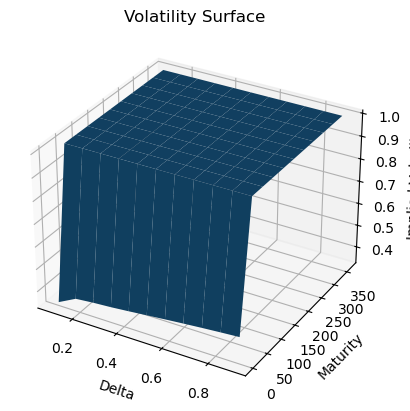

In [66]:
vae_gen.refresh()
vae_gen.plot(delta_range=(0.1, 0.9), maturity_range=(1, 360))

## grid adjust, filter out large ttm, vae vanilla model


In [46]:
delta_grid = np.linspace(0.1, 0.9, 9)
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360])
model_name = "vae_shortttm"
train_model = True
load_model = False
save_model = True
data_dir = CSV_PATH + "/predicted_vol_surfaces_shortttm.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 50
SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer_shortttm_2 = Trainer(model_name)
trainer_shortttm_2.create_model()

with open(data_dir, "r") as f:
    data = json.load(f)

vol_surfaces = []
for key in data:
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
dummy_labels = torch.zeros(len(data_tensor))

dataset = TensorDataset(data_tensor, dummy_labels)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer_shortttm_2.batch_size,
    shuffle=True
)

# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer_shortttm_2.train(train_loader)

if save_model:
    torch.save(
        trainer_shortttm_2.model.state_dict(), f"params/{trainer_shortttm_2.model_name}.pth"
    )


[2025-04-20 11:35:12] [INFO] src.train (60) : Using device: mps
[2025-04-20 11:35:12] [INFO] train (35) : Epoch 1/50
[2025-04-20 11:35:12] [INFO] src.train (179) : Loss: 5.1497
[2025-04-20 11:35:12] [INFO] train (35) : Epoch 2/50
[2025-04-20 11:35:12] [INFO] src.train (179) : Loss: 2.6822
[2025-04-20 11:35:12] [INFO] train (35) : Epoch 3/50
[2025-04-20 11:35:12] [INFO] src.train (179) : Loss: 1.3049
[2025-04-20 11:35:12] [INFO] train (35) : Epoch 4/50
[2025-04-20 11:35:12] [INFO] src.train (179) : Loss: 0.8611
[2025-04-20 11:35:12] [INFO] train (35) : Epoch 5/50
[2025-04-20 11:35:12] [INFO] src.train (179) : Loss: 0.6453
[2025-04-20 11:35:12] [INFO] train (35) : Epoch 6/50
[2025-04-20 11:35:12] [INFO] src.train (179) : Loss: 0.5671
[2025-04-20 11:35:12] [INFO] train (35) : Epoch 7/50
[2025-04-20 11:35:12] [INFO] src.train (179) : Loss: 0.6386
[2025-04-20 11:35:12] [INFO] train (35) : Epoch 8/50
[2025-04-20 11:35:12] [INFO] src.train (179) : Loss: 0.6668
[2025-04-20 11:35:12] [INFO] tra

In [47]:
trainer_shortttm_2.load_model( f"params/{trainer_shortttm_2.model_name}.pth")

[2025-04-20 11:35:13] [INFO] src.train (136) : Model loaded from params/vae_shortttm.pth


In [48]:
vae_gen = VAEVolSurface(
    vae_model=trainer_shortttm_2.model
)

vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)

array([[0.1900762 , 0.19079994, 0.21023634, 0.20492408, 0.22000556,
        0.21796528, 0.20234233],
       [0.18718477, 0.19070292, 0.17845584, 0.17175534, 0.17744797,
        0.18050256, 0.17544022],
       [0.18892682, 0.18637793, 0.17734435, 0.18029064, 0.17775768,
        0.17910473, 0.18046542],
       [0.19984716, 0.18951914, 0.18180507, 0.18147647, 0.18150738,
        0.18835445, 0.19185542],
       [0.20664161, 0.1952039 , 0.19181892, 0.19958869, 0.19727416,
        0.20230587, 0.21067451],
       [0.2033783 , 0.20101981, 0.19900289, 0.21477666, 0.21029176,
        0.21531618, 0.22136472],
       [0.20556042, 0.20660509, 0.21688183, 0.216225  , 0.22331299,
        0.22728659, 0.23918237],
       [0.22297423, 0.21902207, 0.2335941 , 0.23279949, 0.24759094,
        0.25078392, 0.26678127],
       [0.25758082, 0.2535546 , 0.24845465, 0.26426703, 0.28328213,
        0.28969595, 0.38218623]], dtype=float32)

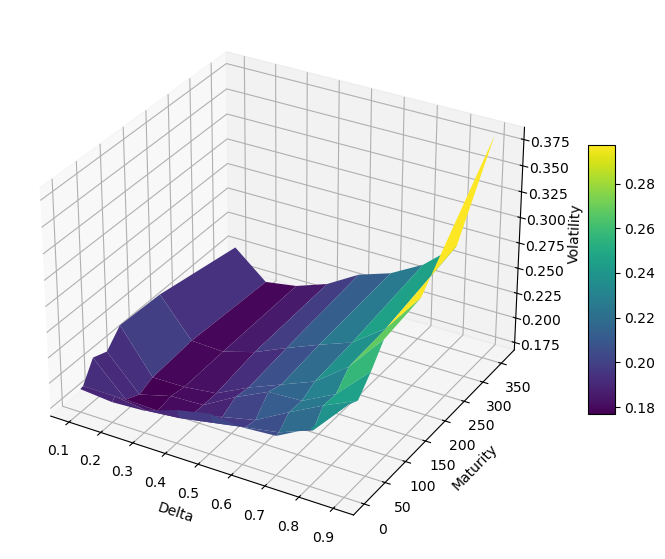

In [49]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
vol_to_plot = vae_gen.predict_grid(delta=delta_grid, maturity=maturity_grid)
maturity, delta = np.meshgrid(maturity_grid, delta_grid)

# Plot the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(delta, maturity, vol_to_plot, cmap='viridis')  # Swap maturity and delta

# Add labels and color bar
ax.set_xlabel('Delta')  # Update label
ax.set_ylabel('Maturity')  # Update label
ax.set_zlabel('Volatility')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.show()

In [15]:
maturity.shape

(7, 9)

# vae pw 1

In [16]:
model_name = "vae_v3"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer_vae_pw_i = Trainer(model_name)
trainer_vae_pw_i.create_model()

[2025-04-18 15:15:15] [INFO] src.train (60) : Using device: mps


vae_pw_i 111111111


In [17]:
dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer.batch_size,
    shuffle=True
)

In [18]:
# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer_vae_pw_i.train(train_loader)

[2025-04-18 15:15:27] [INFO] train (3) : Epoch 1/10
[2025-04-18 15:16:31] [INFO] src.train (180) : Loss: 0.0049
[2025-04-18 15:16:31] [INFO] train (3) : Epoch 2/10
[2025-04-18 15:17:34] [INFO] src.train (180) : Loss: 0.0038
[2025-04-18 15:17:34] [INFO] train (3) : Epoch 3/10
[2025-04-18 15:18:36] [INFO] src.train (180) : Loss: 0.0037
[2025-04-18 15:18:36] [INFO] train (3) : Epoch 4/10
[2025-04-18 15:19:38] [INFO] src.train (180) : Loss: 0.0037
[2025-04-18 15:19:38] [INFO] train (3) : Epoch 5/10
[2025-04-18 15:20:41] [INFO] src.train (180) : Loss: 0.0036
[2025-04-18 15:20:41] [INFO] train (3) : Epoch 6/10
[2025-04-18 15:21:43] [INFO] src.train (180) : Loss: 0.0036
[2025-04-18 15:21:43] [INFO] train (3) : Epoch 7/10
[2025-04-18 15:22:46] [INFO] src.train (180) : Loss: 0.0036
[2025-04-18 15:22:46] [INFO] train (3) : Epoch 8/10
[2025-04-18 15:23:50] [INFO] src.train (180) : Loss: 0.0036
[2025-04-18 15:23:50] [INFO] train (3) : Epoch 9/10
[2025-04-18 15:24:53] [INFO] src.train (180) : Loss:

In [19]:
trainer_vae_pw_i.load_model( f"params/{trainer_vae_pw_i.model_name}.pth")

[2025-04-18 15:27:35] [INFO] src.train (137) : Model loaded from params/vae_v3.pth


In [20]:
def normal_rng(shape, mean=0.0, std=1.0):
    rng = np.random.default_rng(seed=42)
    while True:
        yield rng.normal(loc=mean, scale=std, size=shape)

test_rng = normal_rng(4)

maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [21]:
vae_gen = VAEPWVolSurface(
    vae_model=trainer_vae_pw_i.model
)

In [22]:
vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)

array([[0.1844375 , 0.2504348 , 0.5571426 , 0.9690489 , 0.9987539 ,
        0.9999999 , 1.        , 1.        ],
       [0.18603668, 0.25392935, 0.5553342 , 0.9684381 , 0.9987305 ,
        0.9999999 , 1.        , 1.        ],
       [0.18798424, 0.25693133, 0.5559495 , 0.96781564, 0.9987066 ,
        0.9999999 , 1.        , 1.        ],
       [0.18976824, 0.25995648, 0.5567843 , 0.9671814 , 0.9986823 ,
        0.9999999 , 1.        , 1.        ],
       [0.19144244, 0.2629748 , 0.5572487 , 0.96653503, 0.99865746,
        0.9999999 , 1.        , 1.        ],
       [0.1931149 , 0.26629263, 0.557327  , 0.9658668 , 0.99863225,
        0.9999999 , 1.        , 1.        ],
       [0.19437581, 0.26974356, 0.5570612 , 0.9651248 , 0.99860567,
        0.9999999 , 1.        , 1.        ],
       [0.19556119, 0.27297026, 0.5567909 , 0.96436733, 0.99857724,
        0.9999999 , 1.        , 1.        ],
       [0.1967521 , 0.27622098, 0.55931777, 0.9634752 , 0.9985459 ,
        0.9999999 , 1.      

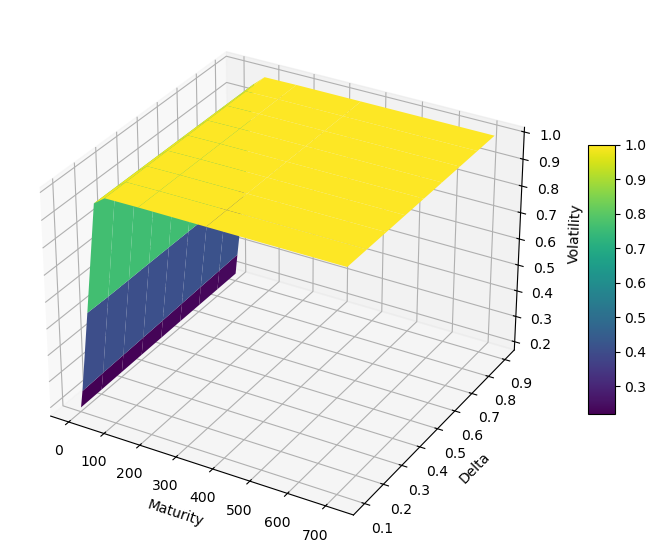

In [26]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
vol_to_plot = vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)
maturity, delta = np.meshgrid(maturity_grid, delta_grid)

# Plot the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(maturity, delta, vol_to_plot, cmap='viridis')

# Add labels and color bar
ax.set_xlabel('Maturity')
ax.set_ylabel('Delta')
ax.set_zlabel('Volatility')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.show()

In [25]:
df['impl_volatility'].describe()

count    1.306655e+06
mean     2.202117e-01
std      8.490786e-02
min      3.264800e-02
25%      1.613140e-01
50%      2.086740e-01
75%      2.620100e-01
max      5.791611e+00
Name: impl_volatility, dtype: float64